# Hypothesis 2 - Accidents location

## Data loading, cleaning

Load packages

In [1]:
import pandas as pd
import geopandas
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import contextily as ctx
import sklearn.cluster

import data_loader as dl

Load data and convert to geopandas.

In [2]:
df = dl.load_data(2021, 2021)
df['obec'] = df['lokalita nehody'] == 1  # obec
df = df.loc[(df['reg'] == "JHM"), ['d', 'e', 'obec']]

# EPSG: 5514 is lat lon
df = df[(~df["d"].isin([np.nan, np.inf, -np.inf])) & (~df["e"].isin([np.nan, np.inf, -np.inf]))]  # only valid lon lat
gdf = geopandas.GeoDataFrame(df, geometry=geopandas.points_from_xy(df["d"], df["e"]), crs="EPSG:5514")
gdf = gdf.drop(["d", "e"], axis=1)

# to local Czech crs
gdf = gdf.to_crs("EPSG:3857").reset_index(drop=True)
gdf.reset_index(inplace=True)  # id for cluster_accidents cnt
gdf.head()

,index,obec,geometry
0,0,False,POINT (1865033.691 6299480.888)
1,1,False,POINT (1816579.662 6318303.753)
2,2,False,POINT (1848322.299 6295923.239)
3,3,True,POINT (1858141.460 6318547.142)
4,4,True,POINT (1879308.413 6301674.513)


## Modeling

Because we want to see location with hight accident rate, we group them together with K-Means. According to
https://scikit-learn.org, MiniBatchKMeans has slightly different results from KMeans, but is much faster. 50 clusters
give visually nice results.

In [5]:
def cluster_accidents(gdf_c, cluster_cnt):
    """
    Get location and size for each cluster
    """
    # create model
    coords = np.dstack([gdf_c.geometry.x, gdf_c.geometry.y]).reshape(-1, 2)
    model = sklearn.cluster.MiniBatchKMeans(n_clusters=cluster_cnt)
    result = model.fit(coords)

    # get data
    gdf_c["cls_lab"] = result.labels_
    gdf_c = gdf_c.dissolve(by="cls_lab", aggfunc={"index": "count"})

    # centers
    centers = geopandas.GeoDataFrame(
        geometry=geopandas.points_from_xy(result.cluster_centers_[:, 0], result.cluster_centers_[:, 1]),
        crs=gdf_c.crs.to_string())

    # add counts
    gdf_c = gdf_c.merge(centers, left_on="cls_lab", right_index=True).rename(columns={"index": "count"}).set_geometry(
        "geometry_y")

    return gdf_c

Compute data.

In [6]:
obec = [True, False]
cluster_sizes = [50, 30]

gdf_cluster_res = []
for i in range(2):
    gdf_i = gdf.loc[gdf['obec'] == obec[i]]
    gdf_cluster = cluster_accidents(gdf_i, cluster_sizes[i])
    gdf_cluster_res.append(gdf_cluster)

gdf_cluster_res[0].head()

/home/awesome/anaconda3/envs/oznal_conda/lib/python3.9/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/awesome/anaconda3/envs/oznal_conda/lib/python3.9/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,geometry_x,count,geometry_y
cls_lab,,,
0,"MULTIPOINT (1885796.774 6259569.032, 1885955.1...",11,POINT (1894097.625 6259964.132)
1,"MULTIPOINT (1842848.832 6299280.076, 1842851.0...",166,POINT (1847088.870 6302967.243)
2,"MULTIPOINT (1784349.878 6252939.853, 1784489.3...",164,POINT (1787422.197 6250728.475)
3,"MULTIPOINT (1837288.787 6370953.360, 1841519.3...",24,POINT (1845498.394 6367746.512)
4,"MULTIPOINT (1879901.115 6326520.836, 1880384.0...",137,POINT (1892807.387 6323162.258)


Plot data.

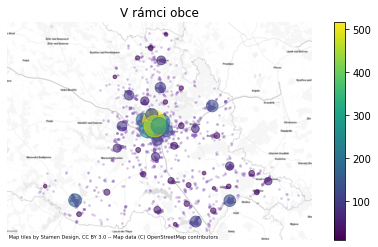

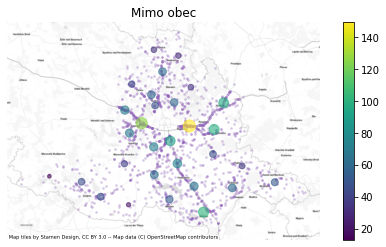

In [7]:
titles = ['V rámci obce', 'Mimo obec']

for i in range(2):
    fig, ax = plt.subplots(1, 1, figsize=(8.27, 4))  # width, height
    # all accidents in the background
    gdf_i = gdf[gdf['obec'] == obec[i]]
    gdf_i.plot(ax=ax, markersize=3, color="tab:purple", alpha=0.25)
    # clusters
    gdf_cluster_res[i].plot(ax=ax, markersize=gdf_cluster_res[i]["count"], column="count", legend=True, alpha=0.6)
    # basemap
    im = ctx.add_basemap(ax, crs=gdf.crs.to_string(), source=ctx.providers.Stamen.TonerLite, zoom=10, alpha=0.90,
                         attribution_size=5)

    # axes style
    ax.set(ylabel='', xlabel='')
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    ax.set_title(titles[i])

    for pos in ["top", "bottom", "right", "left"]:
        ax.spines[pos].set_visible(False)

    fig.savefig(f'./img/geo_{i}.png', dpi=400)